## Imports

In [1]:
import scipy.io
import numpy as np
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape

### 1 Apply Least angle regression and selection (LARS) for the p >> n sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

In [26]:
# Estimate the noise of the data
# Calculate an unbiased OLS estimate using linalg.lstsq
OLS = linalg.lstsq(X,y)
MSE = np.sum((y - X @ OLS[0])**2)/(n-p)
MSE

-3.26406836677077e-26

>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [63]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalizeData(data):
    
    sigma = np.std(data,axis=0)
    data, mu = centerData(data)

    data = data/sigma

    return data, sigma, mu

# Set up cross validation like you did last week
CV = 5 # if K = n leave-one-out, you may try different numbers
kf = KFold(n_splits=CV)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs 
stop = n-math.ceil(n/CV)
K = range(1,stop)

Cp = np.zeros(len(K))
Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, sigma, mu = normalizeData(X_train)
    X_test = (X_test - mu)/sigma

    y_train, mu = centerData(y_train)
    y_test = y_test - mu

    # compute all LARS solutions inside each fold 
    for k in K:
        reg = linear_model.Lars(n_nonzero_coefs=k,fit_path=False,fit_intercept=False,verbose=False)
        reg.fit(X_train, y_train)
        y_est = reg.predict(X_train)
        Err_tr[i,k-1] = np.mean((y_est-y_train)**2)
        y_est = reg.predict(X_test)
        Err_tst[i,k-1] = np.mean((y_est-y_test)**2)
        

err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [64]:
# Compute Cp-statistic, assumption n > p
# elementwise multiplication of list(K) by 2 
err_tst / MSE + [x*2 for x in K] - n
# run LARS on all data and and vary the nonzero coefs from 0 to p. save the betas for Cp

# calculate Cp for each number of nonzero coefs

array([-1.33921518e+27, -1.21065469e+27, -1.17830976e+27, -1.11881201e+27,
       -1.09296937e+27, -9.45492217e+26, -9.31972296e+26, -8.70972414e+26,
       -8.70091321e+26, -8.65932717e+26, -9.82536857e+26, -1.32570734e+27,
       -1.44192416e+27, -1.45702401e+27, -1.71628490e+27, -1.94328649e+27,
       -2.20710599e+27, -4.01469293e+27, -4.08154604e+27, -4.54542171e+27,
       -6.40970557e+27, -8.23453732e+27, -1.12744667e+28, -1.27288078e+28,
       -1.47564975e+28, -1.58230498e+28, -1.91769351e+28, -2.33064668e+28,
       -2.75194333e+28, -3.17833028e+28, -3.56194165e+28, -3.91190343e+28,
       -4.81666053e+28, -5.70983553e+28, -7.85399800e+28, -1.22600661e+29,
       -1.36231585e+29, -1.48660233e+29, -1.86380531e+29, -2.57956694e+29,
       -3.54322844e+29, -4.69780819e+29, -6.01457201e+29, -7.72333817e+29,
       -8.72856116e+29, -1.30295982e+30])

ValueError: x and y must have same first dimension, but have shapes (46,) and (1,)

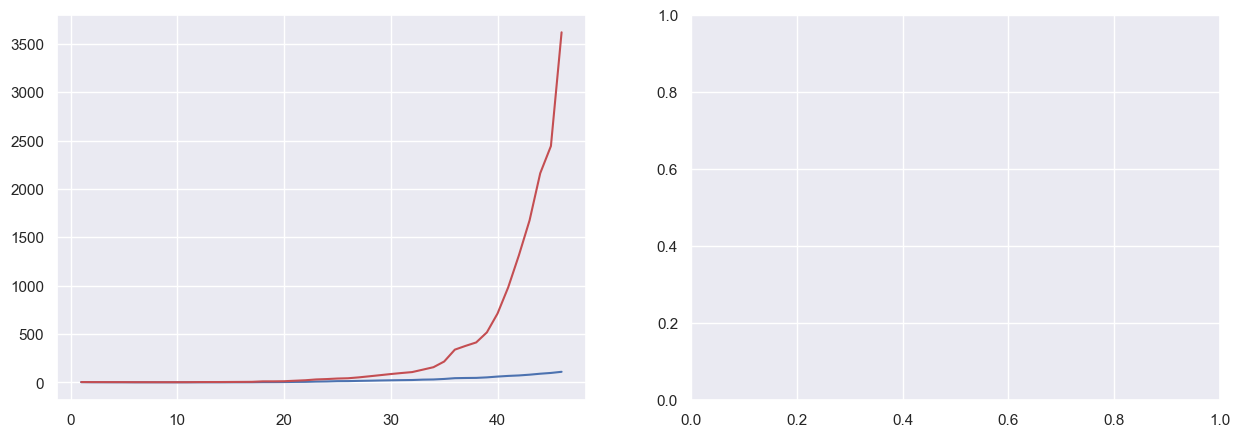

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()